# Trabajo Práctico 1 
### Clasificación sobre datos simulados. 

## Introducción
Para este trabajo, hemos creado una función generadora de minions. Sobre cada minion, hemos medido 200 características que representan habilidades que poseen en distintas tareas (relacionadas al Mal).  

El doctor Nefario ha ideado una fórmula para determinar si un minion es o no apto para concretar su plan para conquistar el mundo. De esta manera ha etiquetado más de 500 minions. Lamentablemente, ha perdido dicha fórmula y necesita seguir decidiendo si nuevos minions son o no aptos para su macabro plan.

Es por esto que nuestro objetivo será construir clasificadores que estimen lo mejor posible la probabilidad de que nuevos minions sean o no aptos para concretar el plan de conquista y así facilitarle las cosas al doctor Nefario.

Por otra parte, ya que el doctor Nefario tuvo problemas con equipos que sobreestiman sus resultados, decidió guardarse varias etiquetas extra que no compartirá con nadie, y que luego utilizará para elegir al mejor equipo, al cual contratará para (de una vez por todas) conquistar el mundo. 


En concreto:

Tendrán disponible una matriz de datos $X$ de $500$ filas en donde cada fila $x^{(i)}$ representa un vector de $200$ características de cada instancia. Es decir, $\textbf{x}^{(i)} = x_1^{(i)}, \dots, x_{200}^{(i)}$ con $i$ entre $1$ y $500$. Además, tendrán y, un vector de $500$ posiciones con dos posibles valores: $True$ y $False$. 

Por otra parte, tendrán disponibles más instancias de evaluación $X_{competencia}$ sin las respectivas etiquetas que utilizaremos para evaluar sus resultados. 



In [1]:
# PREAMBULOS
%matplotlib inline

SEED = 1234

# Commons imports
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from IPython.display import Image, display, HTML
from sklearn.externals.six import StringIO
import pydotplus
from time import time
import itertools
import graphviz
import math

from scipy.stats import randint as sp_randint, uniform, randint, normaltest

import numpy as np
np.set_printoptions(precision=4)
np.random.seed(SEED)

import pandas as  pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 15)
pd.set_option('precision', 4)

import matplotlib.pyplot as plt
import seaborn as sns


import sklearn.model_selection

## Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, validation_curve, learning_curve

import sklearn.preprocessing
import sklearn.ensemble
import sklearn.svm

# Our own classifier
import decision_tree.decision_tree as dt

c:\python36\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# Common functions
def dibujar_arbol(clf):
    dot_data = StringIO()
    sklearn.tree.export_graphviz(clf, out_file=dot_data,  
                    filled=True,
                    special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    display(Image(graph.create_png()))

In [3]:
# Carga de datos
X = pd.read_csv("X.csv", index_col="index")
Y = pd.read_csv("y.csv", index_col="index", dtype=int)  # Cargamos los valores booleanos (True y False)
                                                        # como números (1 y 0) para facilitar el manejo luego. 

X_competencia = pd.read_csv("X_competencia.csv", index_col="index")
Y_competencia_ejemplo = pd.read_csv("y_competencia_ejemplo.csv", index_col="index")
# Descomentar si quieren ver los datos para la competencia:
# display(X_competencia) 
# display(y_competencia_ejemplo)

## Análisis de los datos

In [4]:
print('Descripción del DataFrame con (muestras x predictores)')
display(X.describe())

Descripción del DataFrame con (muestras x predictores)


,0,1,2,3,4,5,6,...,193,194,195,196,197,198,199
count,500.0000,500.0000,500.0000,500.0000,500.0000,500.0000,500.0000,...,500.0000,500.0000,500.0000,500.0000,500.0000,500.0000,500.0000
mean,0.0384,0.0715,0.0056,-0.0103,-0.0436,-0.0208,-0.0571,...,-0.0187,0.0087,-0.0356,-0.1940,0.0250,0.0257,-0.0036
std,1.0153,0.9613,1.0360,1.0230,1.0647,0.9898,1.0000,...,0.9731,0.9716,1.0075,1.0246,0.9934,0.9940,0.9819
min,-3.1722,-2.4596,-2.8834,-3.7474,-2.9987,-3.2014,-3.6855,...,-2.9110,-2.9642,-2.5163,-3.9278,-2.4254,-2.6234,-2.8690
25%,-0.6090,-0.6207,-0.7180,-0.6594,-0.7177,-0.6510,-0.7073,...,-0.6441,-0.6509,-0.6613,-0.8689,-0.6466,-0.6354,-0.6855
50%,0.0602,0.0560,-0.0713,0.0612,-0.0097,-0.0407,-0.0771,...,-0.0473,0.0537,-0.0749,-0.1901,0.0185,-0.0332,-0.0797
75%,0.6334,0.7670,0.7066,0.6699,0.6616,0.6508,0.6029,...,0.6071,0.6860,0.5743,0.4636,0.7041,0.6575,0.6608
max,2.9702,2.7920,2.6905,2.8091,2.9823,2.9342,3.3240,...,3.0983,3.1469,2.9109,2.4942,3.1804,3.0034,2.5107


### Observación:
A primera vista parece que los predictores tienen una distribución gaussiana con media $\approx 0$ y varianza $\approx 1$. Se puede realizar un test de normalidad aunque esto sólo puede permitirnos rechazar la hipótesis nula: "los datos provienen de una distribución normal con media $\mu$ y varianza $\sigma^2$".

In [5]:
def test_normality_on(values, alpha=0.05):
    """
    Computes for each features a normality test.
    
    This function tests the null hypothesis (or H0) that a sample comes
    from a normal distribution.
    
    Parameters
    ----------
    values : array_like
        Matrix of shape (samples x features) containing the values of the features for each sample.
    
    pvalue : float
        A threshold to reject or not H0.
    
    Returns
    -------
    h0_is_rejected : array-like
        A bit-mask which has each index has value 1 if H0 is rejected for the given alpha value,
        0 in other case.
    """
    # we use two different tests
    _statistic, _p_values = normaltest(values)
    # _statistic should not live in [0,4] to reject H0. _k2 is non-negative array.
    # _p_values should be lower than alpha to reject H0. _k2 is an array.
    
    # rejects if at least one of both rejects
    return np.array(
        [
            _p_values[_ith_feature] < alpha or 4 < _statistic[_ith_feature] 
             for _ith_feature in range(len(_p_values))
        ]
    )

normality_is_rejected = test_normality_on(X)

features_which_reject_h0 = []
for index, is_rejected in enumerate(normality_is_rejected):
    if is_rejected:
        features_which_reject_h0.append(index)

print('Se puede rechazar la hipótesis de que provengan de una normal para las features:\n {}'.format(
    features_which_reject_h0
))

Se puede rechazar la hipótesis de que provengan de una normal para las features:
 [2, 3, 6, 10, 18, 33, 46, 83, 94, 97, 106, 108, 119, 128, 138, 142, 157, 160, 165, 168, 179, 191]


Este gráfico muestra que hay correlación lineal mayor a 0.5 entre varios predictores, y con esto no independencia entre los mismos. No podemos decir nada respecto a aquellos predictores $P_1$, $P_2$, con $|\text{Covarianza}(P_1,P_2)| < 0 + \textit{epsilon}$


donde $\textit{epsilon}$ es algún valor que admita un error (ej: [0, 0.05])

### ¿Cuál es el porcentaje de cada clase en la muestra?

In [6]:
display(Y.describe())

class_1_percentage = int(Y.sum()) / len(Y)

print('% Clase 1: {:.2f}\n% Clase 0: {:.2f}'.format(class_1_percentage, 1 - class_1_percentage))

,output
count,500.0000
mean,0.4580
std,0.4987
min,0.0000
25%,0.0000
50%,0.0000
75%,1.0000
max,1.0000


% Clase 1: 0.46
% Clase 0: 0.54


## Ejercicio 1

### Separación de datos

Contarán con una cantidad limitada de datos, por lo cual es importante tomar una buena decisión en el momento de empezar a utilizarlos. En este punto pedimos que evalúen cómo separar sus datos para desarrollo y para evaluación tomando en cuenta la competencia. 

Tamaño conj de entrenamiento: (450, 200), tamaño conj de clases de entrenamiento: (450, 1). porcentaje de clase 1 en conj 0.46.
Tamaño conj de test: (50, 200), tamaño conj de clases de test: (50, 1), porcentaje de clase 1 en conj 0.46.


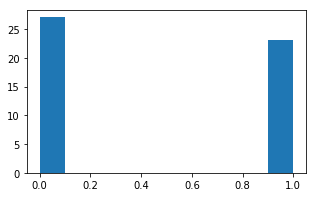

In [7]:
percentage_train = 9.0/10
X_train, X_held_out, Y_train, Y_held_out = sklearn.model_selection.train_test_split(
    X, Y, train_size=percentage_train, stratify=Y
)

# Just to check sizes and percentage of class 1 in each one
print("Tamaño conj de entrenamiento: {}, tamaño conj de clases de entrenamiento: {}. porcentaje de clase 1 en conj {:.2f}.".format(
        X_train.shape, Y_train.shape, int(Y_train.sum())/len(Y_train))
)
print("Tamaño conj de test: {}, tamaño conj de clases de test: {}, porcentaje de clase 1 en conj {:.2f}.".format(
        X_held_out.shape, Y_held_out.shape, int(Y_held_out.sum())/len(Y_held_out))
)

plt.figure(figsize=(5, 3))
plt.hist(np.array(Y_held_out))  # muestra un histograma para la distribución de y.
plt.show()

### ¿Hay correlación entre variables?

Si dos variables son independientes, entonces su correlación es 0. El contrarrecíproco nos permite mostrar que al tener una correlación distinta de 0, las variables no son independientes.


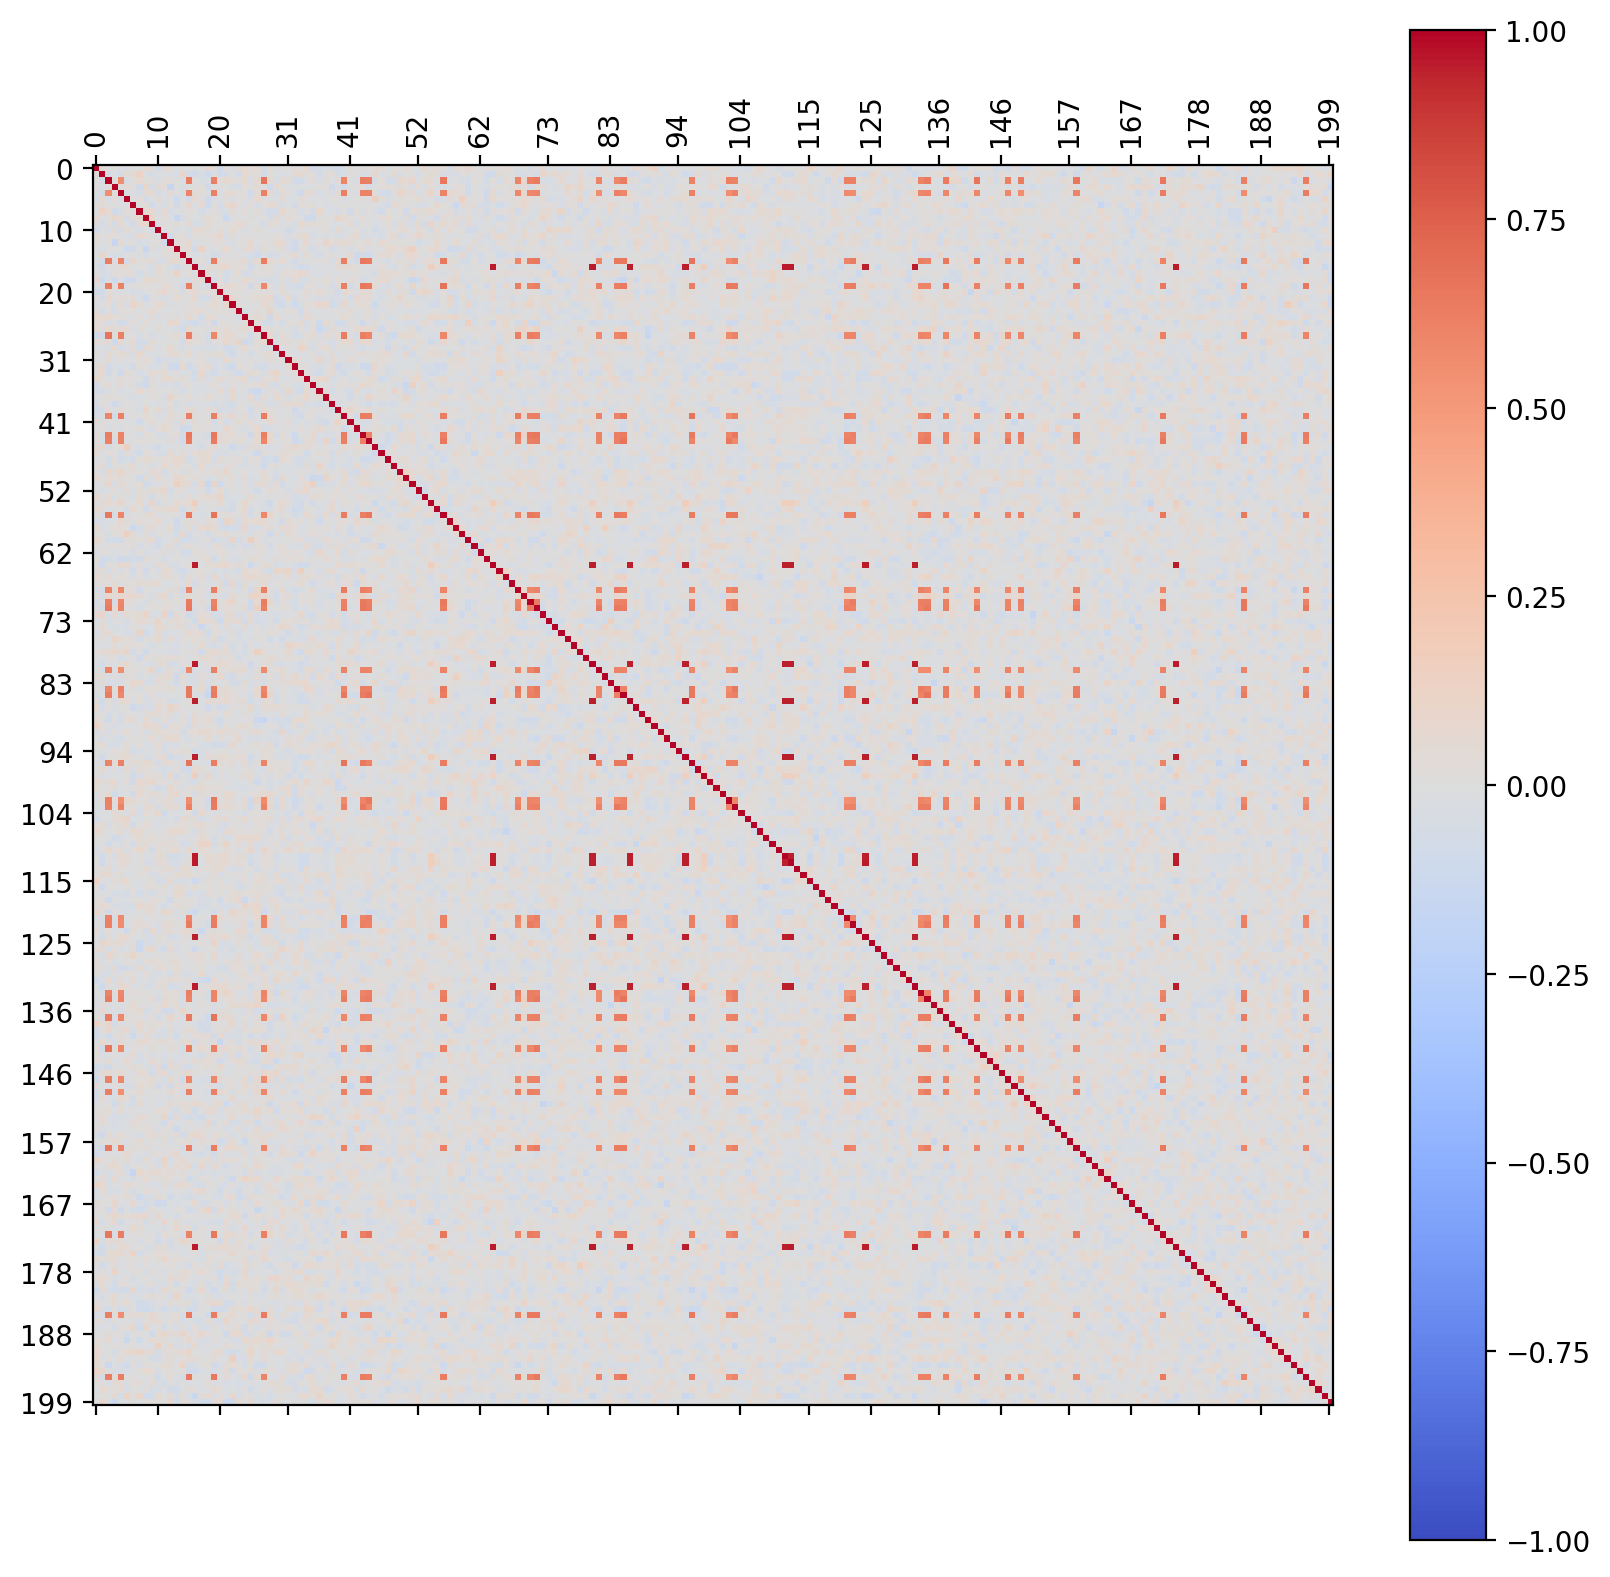

In [8]:
def plot_correlation_between_dataframe_columns(df_features):
    corr = df_features.corr()
    fig = plt.figure(figsize=(10, 10), dpi=200)
    ax = fig.add_subplot(111)
    cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
    fig.colorbar(cax)
    ticks = list(map(int, np.linspace(0,len(X_train.columns)-1,20)))
    ax.set_xticks(ticks)
    plt.xticks(rotation=90)
    ax.set_yticks(ticks)
    ax.set_xticklabels(df_features.columns[ticks])
    ax.set_yticklabels(df_features.columns[ticks])
    plt.show()
    return

plot_correlation_between_dataframe_columns(X)

## Ejercicio 2

### Construcción de modelos

Para este punto, la tarea consiste en construir y evaluar modelos de tipo árbol de decisión, de manera de obtener una estimación realista de la performance de los mismos. 

1. Entrenar un árbol de decisión con altura máxima 3 y el resto de los hiperparámetros en default. 
2. Estimar la performance del modelo utilizando K-fold cross validation con K = 5, con las métricas “Accuracy” y “ROC AUC”. Para ello, se pide medir la performance en cada partición tanto sobre el fold de validación como sobre los folds de entrenamiento. Luego, completar la primera tabla.
3. Entrenar árboles de decisión para cada una de las siguientes combinaciones y completar la segunda tabla.

----

**EJERCICIO EXTRA: Usar la implementación de árboles de decisión que realizaron para la guía de ejercicios de la materia. Adaptarla para que cumpla con la interfaz requerida por sklearn, asegurarse de que funcione con variables continuas y reproducir las tablas anteriores.   **

----

,Accuracy (entrenamiento),Accuracy (validación),AUC ROC (entrenamiento),AUC ROC (validación)
Fold de validación,,,,
1,0.8134,0.6923,0.8799,0.7221
2,0.8250,0.6556,0.8734,0.7349
3,0.8222,0.6111,0.8798,0.6954
4,0.8250,0.7333,0.8725,0.7822
5,0.8033,0.5955,0.8576,0.7149


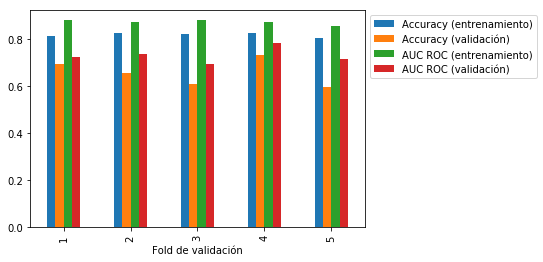

In [9]:
def plot_accuracy_and_auc_roc_on_train_and_test(metrics_results,
        tabble_header='Resultado Ejercicio 2.2: accuracy y roc auc en árboles de decisión con altura máxima de 3'):
    """
    Param metrics_results :type: dict should at least contains keys 
    ['train_accuracy', 'test_accuracy', 'train_roc_auc', 'test_roc_auc'].
    """
    
    df = pd.DataFrame(index=range(1,6))
    df.index.name = "Fold de validación"

    df["Accuracy (entrenamiento)"] = metrics_results['train_accuracy']
    df["Accuracy (validación)"] = metrics_results['test_accuracy']
    df["AUC ROC (entrenamiento)"] = metrics_results['train_roc_auc']
    df["AUC ROC (validación)"] = metrics_results['test_roc_auc']
    display(HTML('<h3> {} </h3>'.format(tabble_header)))
    display(df)

    fig = df.plot(kind="bar")
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()
    
    return

X_train_np = np.array(X_train)
Y_train_np = np.array(Y_train).ravel()


# In order to avoid using the same variable's names in different excercises,
# each excercise is a function with local variables

def excercise_2_2():
    decision_tree = DecisionTreeClassifier(max_depth=3)

    metric_scores = sklearn.model_selection.cross_validate(
        decision_tree, X_train_np, Y_train_np, scoring=('roc_auc', 'accuracy'), cv=5, n_jobs=4
    )

    plot_accuracy_and_auc_roc_on_train_and_test(metric_scores)
    return

excercise_2_2()

,Altura Máxima,Medida de Separación,Promedio AUC ROC (entrenamiento),Promedio AUC ROC (validación)
0,3,Gini,0.8726,0.7299
1,5,Gini,0.9733,0.6393
2,Inifinity,Gini,1.0000,0.6440
3,3,Ganancia de Información,0.8718,0.7386
4,5,Ganancia de Información,0.9739,0.7089
5,Inifinity,Ganancia de Información,1.0000,0.6658


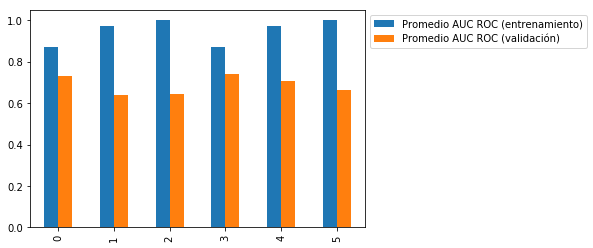

In [10]:
def plot_table_excercise_2_3(metrics_scores,
                             table_header='Resultado Ejercicio 2.3: árboles de decisión con diferentes hiperparámetros'):
    """
    Param metrics_scores :type: dict should at least has 'train_results' and 'test_results' keys
    """
    df = pd.DataFrame(index=range(0,6))

    df['Altura Máxima'] = [3, 5, 'Inifinity'] * 2
    df['Medida de Separación'] = ['Gini'] * 3 + ['Ganancia de Información'] * 3
    df['Promedio AUC ROC (entrenamiento)'] = metrics_scores['train_results']
    df['Promedio AUC ROC (validación)'] = metrics_scores['test_results']
   
    display(HTML("<h3> {} </h3>".format(table_header)))
    display(df)
    
    df.plot(kind="bar")
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()
    
    return

def excercise_2_3():
    metric_scores = { 'train_results' : [], 'test_results' : [] }
            
    for _criterio, _depth in itertools.product(['gini', 'entropy'], [3, 5, None]):
        
        decision_tree = DecisionTreeClassifier(max_depth=_depth, criterion=_criterio)
        
        tree_metric_score = sklearn.model_selection.cross_validate(
            decision_tree, X_train_np, Y_train_np, scoring='roc_auc', cv=5
        )
            
        metric_scores['train_results'].append(np.mean(tree_metric_score['train_score']))
        metric_scores['test_results'].append(np.mean(tree_metric_score['test_score']))
    
    plot_table_excercise_2_3(metric_scores)
        
excercise_2_3()

### Ejercicio Extra: Mi Árbol de naranja lima

,Accuracy (entrenamiento),Accuracy (validación),AUC ROC (entrenamiento),AUC ROC (validación)
Fold de validación,,,,
1,0.7250,0.7333,0.8062,0.7540
2,0.7333,0.6889,0.7895,0.7698
3,0.7389,0.6111,0.8100,0.7229
4,0.7389,0.6889,0.8138,0.7186
5,0.7222,0.7556,0.7927,0.7862


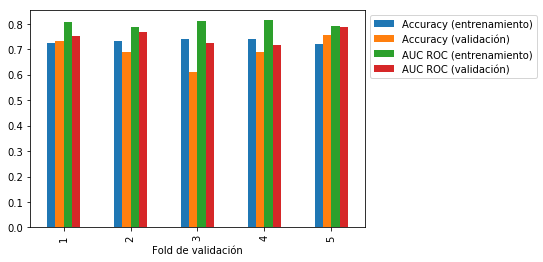

,Altura Máxima,Medida de Separación,Promedio AUC ROC (entrenamiento),Promedio AUC ROC (validación)
0,3,Gini,0.7471,0.6998
1,5,Gini,0.8542,0.6921
2,Inifinity,Gini,0.9566,0.6801
3,3,Ganancia de Información,0.7683,0.6470
4,5,Ganancia de Información,0.8575,0.6954
5,Inifinity,Ganancia de Información,0.9676,0.6429


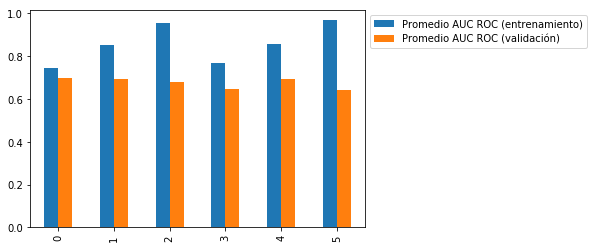

In [11]:
def exercise_2_with_our_tree():
    # si no fijamos una cantidad de atributos nuestro arbol no llega al 2017
    decision_tree = dt.MiClasificadorArbol(criteria='entropy', max_depth=3, max_attr=200)    
    results = sklearn.model_selection.cross_validate(
        decision_tree, X_train_np, Y_train_np, scoring=('roc_auc', 'accuracy'), cv=5
    )
    plot_accuracy_and_auc_roc_on_train_and_test(results)
    return

def excercise_2_3_with_our_tree():
    _metric_scores = { 'train_results' : [], 'test_results' : [] }
    for _criterio, _depth in itertools.product(['gini', 'entropy'], [3, 5, None]):
        # TODO: Add criterio to our tree and admit _deph None
        decision_tree = dt.MiClasificadorArbol(criteria=_criterio, max_depth=_depth, max_attr=10)

        tree_metric_score = sklearn.model_selection.cross_validate(
            decision_tree, X_train_np, Y_train_np, scoring='roc_auc', cv=2
        )

        _metric_scores['train_results'].append(np.mean(tree_metric_score['train_score']))
        _metric_scores['test_results'].append(np.mean(tree_metric_score['test_score']))
    
    plot_table_excercise_2_3(_metric_scores)
    return

exercise_2_with_our_tree()
excercise_2_3_with_our_tree()

## Ejercicio 3: Comparación de algoritmos


Se pide explorar distintas combinaciones de algoritmos de aprendizaje e hiperparámetros, de manera de buscar una performance óptima. Para este ejercicio es necesario que evalúen posibilidades utilizando la técnica de Grid Search. Como métrica de performance, usar siempre el área bajo la curva (AUC ROC) resultante de 5-fold cross-validation. 

Algoritmos a probar: KNN, árboles de decisión, LDA, Naive Bayes y SVM. Hiperparámetros: Revisar la documentación de cada uno para la búsqueda de combinaciones prometedoras.  

Se pide generar un reporte que contenga: 

1. Una descripción de las distintas combinaciones consideradas y su performance asociada (las que consideren relevantes, con al menos la mejor combinación para cada algoritmo). 

1. Una breve explicación de los factores que creen que produjeron dicho resultado. 

En este punto evaluaremos tanto los hiperparámetros elegidos como las conclusiones relacionadas a por qué piensan que ciertos algoritmos funcionan mejor que otros para estos datos. 



----

**EJERCICIO EXTRA**: Utilizar RandomizedSearchCV con rangos de parámetros que contengan a los utilizados en el GridSearch. Analizar si se encontraron mejores combinaciones de parámetros que no hayan sido tenidas en cuenta con el GridSearch y cuál fue la diferencia de tiempo de ejecución. 

----

In [12]:
def top_results(grid, top=5, skip=0):
    print("Top {} Salteando {} combinaciones".format(top, skip))
    df = pd.DataFrame(grid.cv_results_["params"])
    df["mean_score_validation"] = grid.cv_results_["mean_test_score"]
    df["mean_score_training"] = grid.cv_results_["mean_train_score"]
    display(df.sort_values(by="mean_score_validation", ascending=False).head(top+skip).tail(top))
    return

def apply_grid_search_on_classifier_and_parameters(
    classifier, classifier_parameters, _X_train, _Y_train, metrics_names=('roc_auc'), cv=5, 
    n_jobs=4, error_score='raise'):
    
    _clf = GridSearchCV(
        classifier, classifier_parameters, scoring=metrics_names, cv=cv, n_jobs=n_jobs,
        error_score=error_score
    )
    
    return _clf.fit(_X_train, _Y_train)    

### Grid Search sobre clasificadores

### Resultados

### Árboles de decisión

In [13]:
def tree_grid_search_parametrization(_X_train, _Y_train, _error_score='raise'):
    
    _amount_of_features_in_dataset = _X_train.shape[1]
    _possible_max_features_ = list(range(25, min(200, _amount_of_features_in_dataset), 10)) \
        + list(filter(lambda x: x is None or x <= _amount_of_features_in_dataset, [7, 14, 20, None]))
    tree_arguments = [
        {
            'criterion': ['gini', 'entropy'],
            'splitter': ['best', 'random'],
            'max_depth': list(range(3, 13, 3)) + list(range(15, 36, 10)) + [None],
            'max_features': _possible_max_features_,
            'max_leaf_nodes': list(range(10, 501, 50)) + [None]
        }
    ]
    
    tree_classifier = DecisionTreeClassifier(random_state = SEED) # it doesn't seem to be taking numpy.seed
    
    return apply_grid_search_on_classifier_and_parameters(
        tree_classifier, tree_arguments, _X_train, _Y_train, error_score=_error_score
    )

grid_tree = tree_grid_search_parametrization(X_train_np, Y_train_np)
top_results(grid_tree,10)

Top 10 Salteando 0 combinaciones


,criterion,max_depth,max_features,max_leaf_nodes,splitter,mean_score_validation,mean_score_training
3938,entropy,3.0,55.0,10.0,best,0.7751,0.8980
3948,entropy,3.0,55.0,260.0,best,0.7731,0.9166
3956,entropy,3.0,55.0,460.0,best,0.7731,0.9166
3940,entropy,3.0,55.0,60.0,best,0.7731,0.9166
3942,entropy,3.0,55.0,110.0,best,0.7731,0.9166
3944,entropy,3.0,55.0,160.0,best,0.7731,0.9166
3946,entropy,3.0,55.0,210.0,best,0.7731,0.9166
3950,entropy,3.0,55.0,310.0,best,0.7731,0.9166
3952,entropy,3.0,55.0,360.0,best,0.7731,0.9166
3954,entropy,3.0,55.0,410.0,best,0.7731,0.9166


### Parámetros
Se varía la forma de medir la calidad de una separación (criterion) en un nodo como también la forma en la que se elige entre las posibles (splitter). Se varía también la cantidad máxima de predictores a considerar para buscar la mejor separación. 
Nos pareció de interés variar la altura y la cantidad de hojas permitidas en el árbol para ver como generaliza una árbol pequeño o con pocas hojas respecto a uno sin limitación.

### Resultados
Se obtuvieron mejores resultados en los datos de validación respecto a los obtenidos en el ejercicio 2.2 y 2.3 con resultados en los datos de entrenamiento menores (el top 10 está por debajo de %90).

Si nuestros datos hubieran sido linealmente separables, hubieramos obtenido mejores resultados.
    
    
Los predictores se permutan en cada nodo previo a la elección de sobre cual se va a separación (si es que lo hace) el nodo. Por lo tanto para los mismos parámetros y datos se puede obtener en árboles distintos. Aunque la documentación indica que se toma la misma semilla que numpy utiliza (la cual es seteada por nosotros en $\textit{SEED}$) el comportamiento continuó siendo al azar. Se fijó el parámetro $\textit{random_state}$ con el mismo valor que la seed de numpy para obtener de manera determinista un árbol.

### Preguntas a realizarse

1. ¿Qué features separa y qué pinta tiene el mejor árbol obtenido?
2. ¿Cómo afecta el cambiar de algunos hiperaparámetros?
    + ¿Cómo cambia el auc roc mientras aumentamos la profundidad máxima del árbol?
    + ¿Cómo cambia el auc roc mientras aumentamos la cantidad de hojas máxima del árbol?

1)¿Qué features separa y cómo el mejor árbol obtenido?

In [14]:
## Functions for DecisionTreeClassifier and its internal Tree struct

def create_decision_tree_classifier_with_params(parameter_combination):
    criterion = parameter_combination['criterion']
    max_depth = parameter_combination['max_depth']
    max_features = parameter_combination['max_features']
    max_leaf_nodes = parameter_combination['max_leaf_nodes']
    splitter = parameter_combination['splitter']
    
    return DecisionTreeClassifier(
            criterion=parameter_combination['criterion'],
            max_depth= None if max_depth is None or np.isnan(max_depth) else int(max_depth),
            max_features= None if max_features is None or np.isnan(max_features) else int(max_features),
            max_leaf_nodes= None if max_leaf_nodes is None or np.isnan(max_leaf_nodes) else int(max_leaf_nodes),
            splitter=parameter_combination['splitter'],
            random_state=SEED
    )

def calculate_nodes_depth_and_leaves(tree_classifier):
    """
    Param tree_classifier :type: DecisionTreeClassifier.
    
    Traverse the internal tree_ structure tree_classifier in order to compute, its depth, amount of nodes
    and amount of leaves.
    
    Trivial tree (only one node) has depth equals to 0.
    """
    n_nodes = tree_classifier.tree_.node_count
    children_left = tree_classifier.tree_.children_left
    children_right = tree_classifier.tree_.children_right

    # The tree structure can be traversed to compute various properties such
    # as the depth of each node and whether or not it is a leaf.
    max_depth_used = -1
    leaves_amount = 0
    stack = [(0, max_depth_used)]  # (root_node_id, its_parent_depth)
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()
        
        max_depth_used = max(max_depth_used, parent_depth+1) # keep max depth
        
        # If it's a leaf its childs are equal
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            leaves_amount += 1
    
    return n_nodes, max_depth_used, leaves_amount # nodes_count, max_depth_used, leaves_count 

criterion                entropy
max_depth                      3
max_features                  55
max_leaf_nodes                10
splitter                    best
mean_score_validation     0.7751
mean_score_training        0.898
Name: 3938, dtype: object
Cantidad de nodos 19
Altura del árbol 4
Cantidad de hojas 10


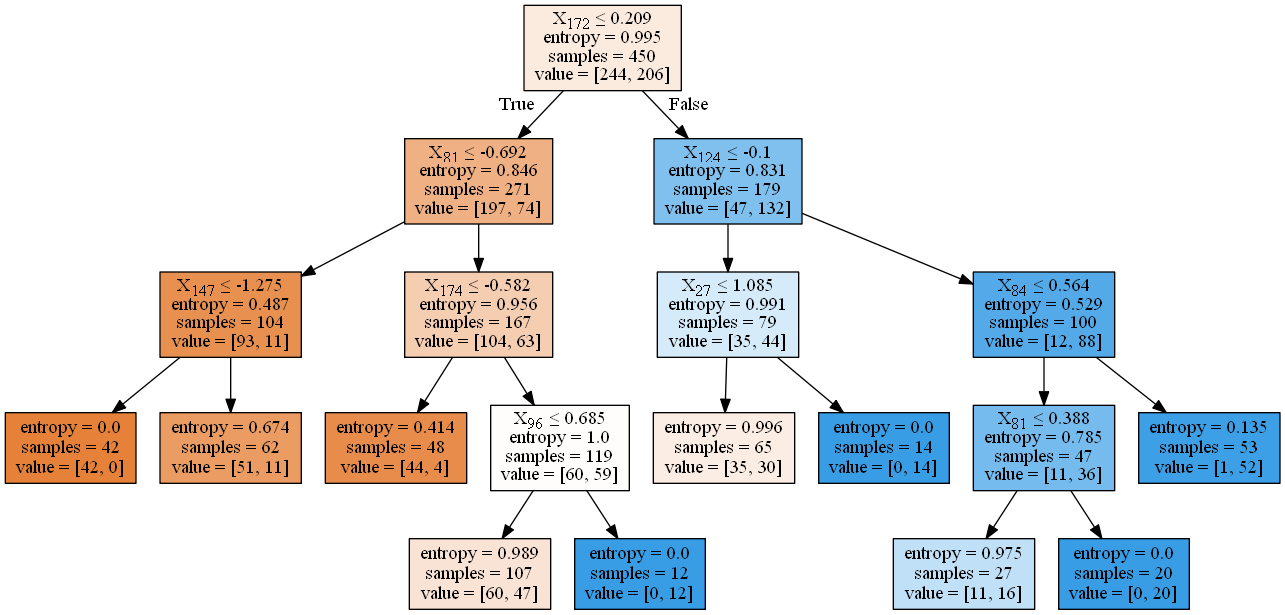

In [17]:
def print_top_trees(grid, top=10):
    df = pd.DataFrame(grid.cv_results_["params"])
    df["mean_score_validation"] = grid.cv_results_["mean_test_score"]
    df["mean_score_training"] = grid.cv_results_["mean_train_score"]
    df = df.sort_values(by="mean_score_validation", ascending=False).head(top)
    
    for _, _parameters in df.iterrows():
        print(_parameters)
        best_tree = create_decision_tree_classifier_with_params(_parameters)
        best_tree.fit(X_train_np, Y_train_np)
        print('Cantidad de nodos {}\nAltura del árbol {}\nCantidad de hojas {}'.format(
                *calculate_nodes_depth_and_leaves(best_tree))
        )
        dibujar_arbol(best_tree)
    return

#plot first 10 trees to see their shape and the features they used to split in each node 
print_top_trees(grid_tree,1)

### Observación:
En el top 10 vemos presentes muchos arboles con criterio $\textit{entropy}$ con el mismo valor de AUC ROC. Esto es sólo ocurre porque encontramos el mismo árbol con una altura final de 3 repetido para cada $\textit{max_depth}$. No se expande más debido al threshold de mínima reducción de impuereza (default = 0.0).

Si evitamos estos resultados con misma altura, podremos ver

2) ¿Cómo afecta el cambiar de algunos hiperaparámetros?
    - ¿Cómo cambia el auc roc mientras aumentamos la profundidad máxima del árbol?
    - ¿Cómo cambia el auc roc mientras aumentamos la cantidad de hojas máxima del árbol?
    

Para ver la primera pregunta consideraramos los árboles sin límite en la cantidad de hojas y en la segunda los árboles sin límite en la cantidad profundidad. Creamos un árbol para cada combinación de hiperparámetros utilizando la misma semilla pero en este caso fiteamos sobre todo el set de datos de entrenamiento y no sobre un fold sabiendo que el árbol no será exactamente el mismo pero 'similar' (el valor que nos muestra GridSearch es un promedio de los obtenidos por los folds).

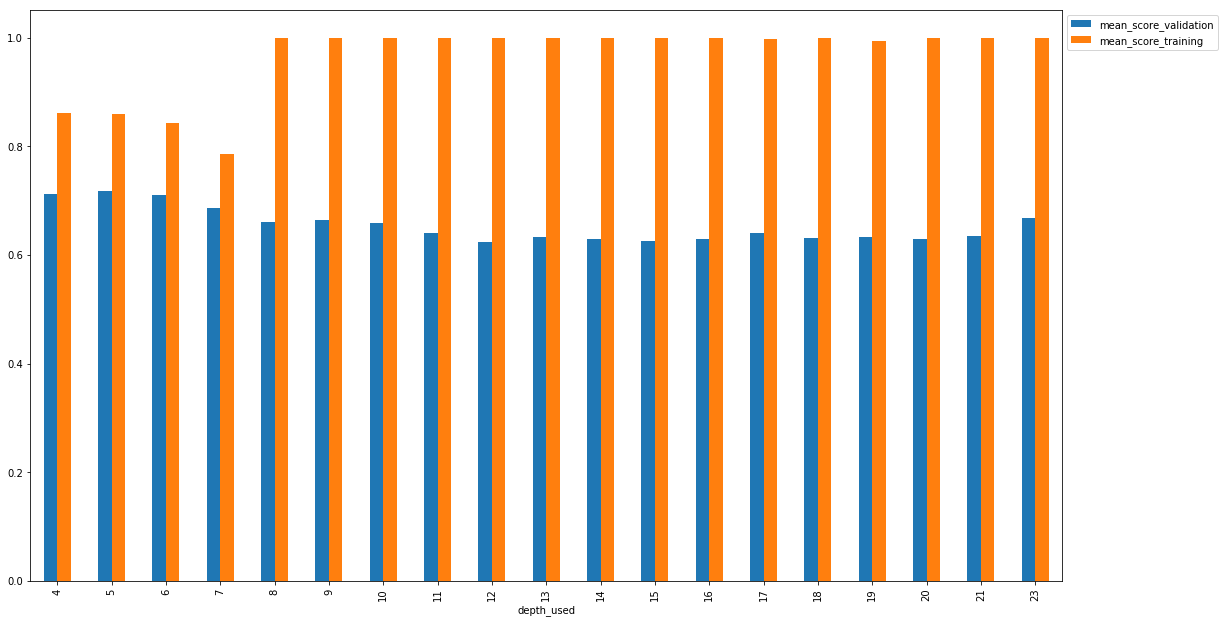

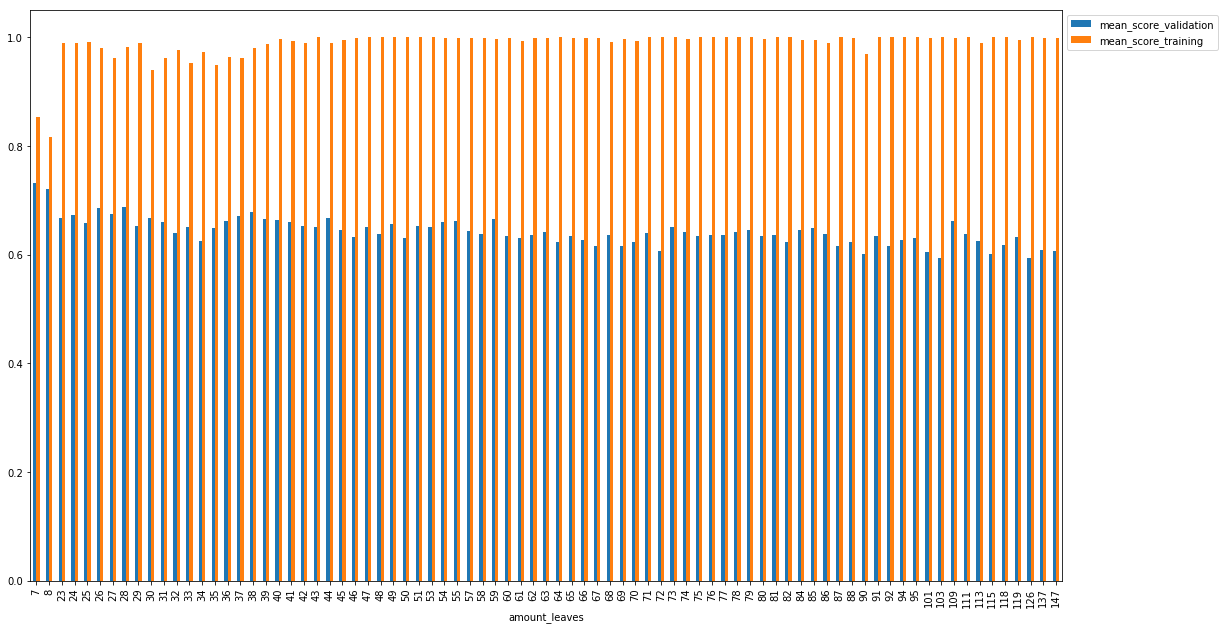

In [18]:
def add_nodes_depth_and_leaves_features_of_tree_for_each_parameter_combination(
    parameter_combination_df, _X_train, _Y_train):
    """
    Param parameter_combination_df :type: DataFrame contains a serie of hiperparameters to create
    DecisionTreeClassifiers.
    
    For each one compute the depth and amount of leaves and nodes of the internval tree structure.
    This is information is returned in the input DataFrame as new columns.
    """
    
    amount_nodes = np.zeros(shape=len(parameter_combination_df.index), dtype=np.int64)
    depth_used = np.zeros(shape=len(parameter_combination_df.index), dtype=np.int64)
    amount_leaves = np.zeros(shape=len(parameter_combination_df.index), dtype=np.int64)
    
    _index=0
    for _, parameter_combination in parameter_combination_df.iterrows():
        _tree_classifier = create_decision_tree_classifier_with_params(parameter_combination)
        _tree_classifier.fit(X_train, Y_train)
        amount_nodes[_index], depth_used[_index], amount_leaves[_index] = calculate_nodes_depth_and_leaves(_tree_classifier)
        _index +=1
    
    parameter_combination_df['amount_nodes'] = amount_nodes
    parameter_combination_df['depth_used'] = depth_used
    parameter_combination_df['amount_leaves'] = amount_leaves
    
    return parameter_combination_df

def plot_dataframe_as_bar(dataframe):
    fig = dataframe.plot(kind="bar", figsize=(18.5, 10.5))
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()
    return

def plot_score_while_increasing_depth(df_without_depth_bound, _X_train, _Y_train):
    df_without_depth_bound = add_nodes_depth_and_leaves_features_of_tree_for_each_parameter_combination(
        df_without_depth_bound, _X_train, _Y_train
    )
    
    df_without_depth_bound = df_without_depth_bound.drop(
        columns=['max_depth']
    )[['depth_used','mean_score_validation', 'mean_score_training']].groupby(['depth_used']).mean()
    
    plot_dataframe_as_bar(df_without_depth_bound)
    return

def plot_score_while_increasing_leaves(df_without_leaves_bound, _X_train, _Y_train):
    df_without_leaves_bound = add_nodes_depth_and_leaves_features_of_tree_for_each_parameter_combination(
        df_without_leaves_bound, _X_train, _Y_train
    )
    
    df_without_leaves_bound = df_without_leaves_bound.drop(
        columns=['max_leaf_nodes']
    )[['amount_leaves','mean_score_validation', 'mean_score_training']].groupby(['amount_leaves']).mean()
    
    plot_dataframe_as_bar(df_without_leaves_bound)
    return
    
def plot_score_while_increasing_depth_and_max_feature(grid, top=2):
    df = pd.DataFrame(grid.cv_results_["params"])
    df["mean_score_validation"] = grid.cv_results_["mean_test_score"]
    df["mean_score_training"] = grid.cv_results_["mean_train_score"]
    
    df_without_depth_bound = df[np.isnan(df['max_depth'])].head(top)
    plot_score_while_increasing_depth(df_without_depth_bound, X_train_np, Y_train_np)
    
    df_without_leaves_bound = df[np.isnan(df['max_leaf_nodes'])].head(top)
    plot_score_while_increasing_leaves(df_without_leaves_bound, X_train_np, Y_train_np)
    return

plot_score_while_increasing_depth_and_max_feature(grid_tree, len(grid_tree.cv_results_["mean_test_score"]))

Se puede ver que aumentar el límite de hojas y altura del árbol aumenta en promedio el valor de la métrica auc roc a %100 (aproximadamente) sobre los datos de entrenamiento de manera rápida (cantidad de hojas mayor a 30 o profundidad mayor a 8) mientras que la misma métrica sobre los datos de validación empeoran.

Podemos justificar esto en el overfitting de los árboles al no limitar el tamaño y de los mismos. "Árboles más pequeños, generalizan mejor".

### Naive-Bayes

In [19]:
def naive_bayes_grid_search_parametrization(_X_train, _Y_train):
    """
    The only parameter of Naive-Bayes classifier are the prior probabilities of each class,
    which are automatically calculated as #items_class_1 / #items and #items_class_2 / #items
    if no parameter is specified.
    
    I doesn't make sense trying other prior probabilities than the real ones if the data isn't changing.
    """
    naive_bayes_classifier = GaussianNB()
    naive_arguments = [{}] #None
    
    return apply_grid_search_on_classifier_and_parameters(
        naive_bayes_classifier, naive_arguments, _X_train, _Y_train
    )

grid_naive = naive_bayes_grid_search_parametrization(X_train_np, Y_train_np)
top_results(grid_naive)

Top 5 Salteando 0 combinaciones


,mean_score_validation,mean_score_training
0,0.8218,0.862


### Parámetros

Los parámetros de este clasificador son las probabilidades a priori de cada clase. Esta es información que no conocemos pero que podríamos estimar utilizando la frecuencia relativa de nuestra muestra de entrenamiento. Esto mismo es lo que hace el clasificador si ningún parámetro es especificado.

### Resultados

Los resultados son mejores que los obtenidos utilizando árboles de decisión.

Este método tiene dos asunciones:
    1. Los predictores son independientes entre sí (propio del método)
    2. Las probabilidad condicional P(X_i=x_i/Y=k) de observar el valor x_i para el predictor X_i dado que la muestra x pertenece a la clase k se comporta como una gaussiana (propio de la forma en que está implementado en python)

1) Para responder la primera asunción basta observar la matriz de covarianza de los predictores en el análisis del input. Si dos variables son independientes su covarianza es 0. No vale la vuelta pero podemos usar el contrarrecíproco: si la covarianza entre dos predictores es distinta 0 entonces no son independientes.

Podría ser que al separar los datos en hold out y entrenamiento la matriz de covarianza haya cambiado un poco. Sin embargo se espera observar un resultado similar a la sección de análisis del input.

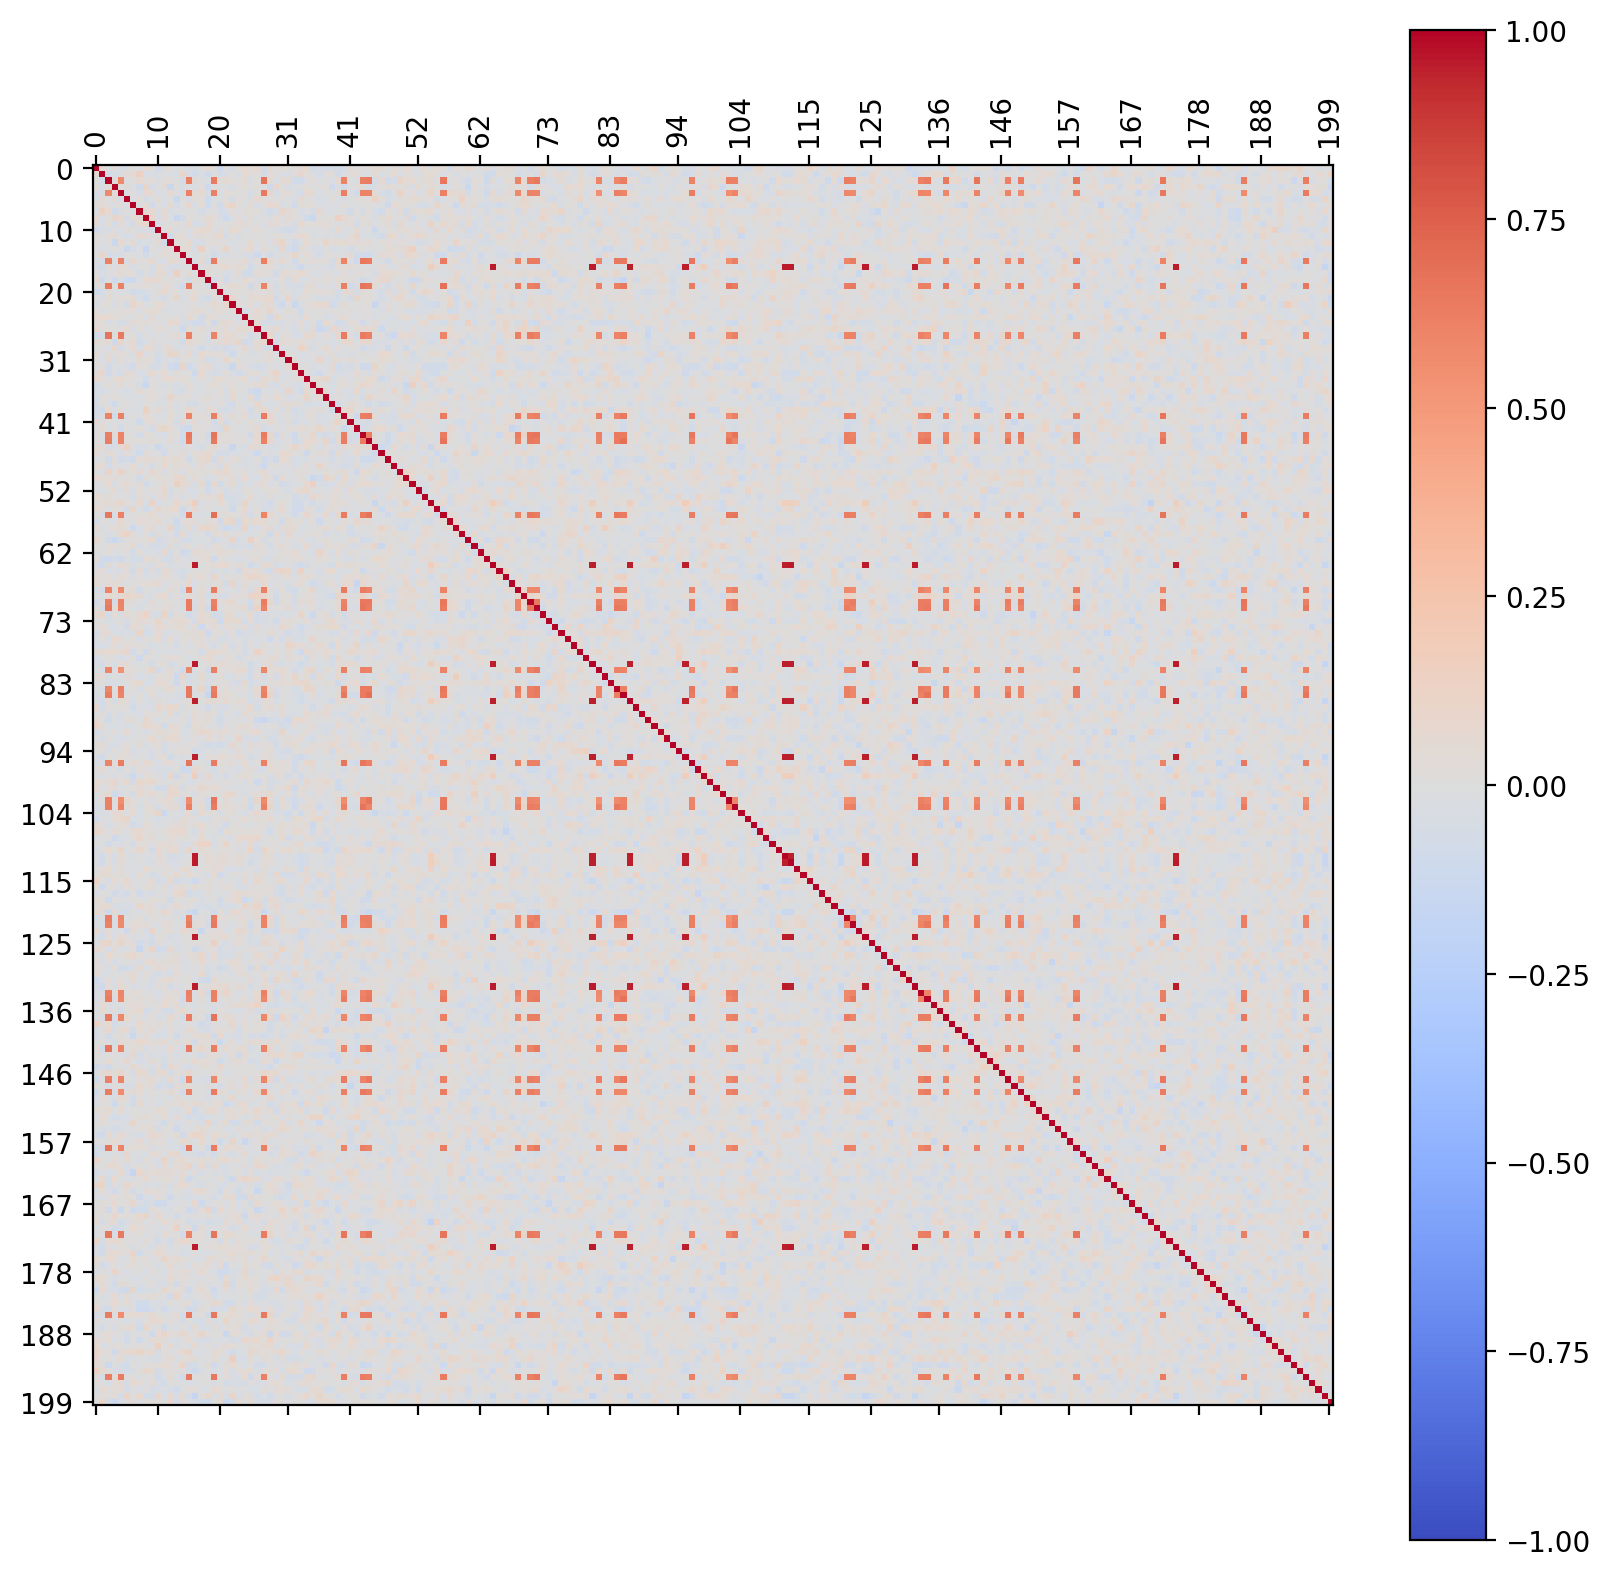

In [20]:
plot_correlation_between_dataframe_columns(X_train)

Los resultados sobre el set de datos de entrenamiento refljan lo mismo que sucede sobre el set de datos completo. Ver http://localhost:8888/notebooks/TP1/TP1.ipynb#%C2%BFHay-correlaci%C3%B3n-entre-variables? .

2) Para observar si era un error asumir que podían aproximarse las probabilidades condicionales con gaussianas se puede hacer test de normalidad, pero ahora sobre los datos que pertenezcan a cada una de las clases por separado.

In [21]:
def plot_naive_bayes_information(_X_train, _Y_train):
    naive_bayes_classifier = GaussianNB().fit(_X_train, _Y_train)
    
    for i in naive_bayes_classifier.classes_:
        print('P(Y={}) = {:.2f}'.format(i, naive_bayes_classifier.class_prior_[i]))
    
    _df_naive = pd.DataFrame(
            data=
            {
                'clase_0_media': naive_bayes_classifier.theta_[0],
                'clase_1_media': naive_bayes_classifier.theta_[1],
                'clase_0_varianza': naive_bayes_classifier.sigma_[0],
                'clase_1_varianza': naive_bayes_classifier.sigma_[1],
            }
    )
    print(_df_naive.describe())
    return _df_naive

#plot_naive_bayes_information(X_train, Y_train)

# see the features when the known label is a fixed class
for _clase in np.unique(Y_train_np):
    print('Descripción de los datos de entrenamiento cuando la clase es {}'.format(_clase))
    print(X_train[Y_train_np==_clase].describe())

_seems_not_normal_0 = test_normality_on(X_train_np[Y_train_np==0])
_seems_not_normal_1 = test_normality_on(X_train_np[Y_train_np==1])

alpha_value = 0.05
print('Se puede rechazar que {} probabilidades condicionales P(X_i=x_i /Y=0) provengan de una \
distribución normal con un nivel de significancia de {}'.format(_seems_not_normal_1.sum(), alpha_value))

print('Se puede rechazar que {} probabilidades condicionales P(X_i=x_i /Y=1) provengan de una \
distribución normal con un nivel de significancia de {}'.format(_seems_not_normal_0.sum(), alpha_value))

print('De estos casos se intersecan {} predictores'.format(_seems_not_normal_0[_seems_not_normal_1].sum()))

Descripción de los datos de entrenamiento cuando la clase es 0
              0         1         2         3         4         5         6  \
count  244.0000  244.0000  244.0000  244.0000  244.0000  244.0000  244.0000   
mean     0.0968    0.1149   -0.3677    0.0390   -0.4285    0.0104   -0.0699   
std      0.9769    0.9304    0.9519    1.0029    1.0023    0.9525    0.9875   
min     -3.1722   -2.4596   -2.8834   -2.8859   -2.9987   -2.4466   -3.6855   
25%     -0.4772   -0.5494   -0.9953   -0.6045   -1.0888   -0.5926   -0.6502   
50%      0.0766    0.1005   -0.3955    0.0913   -0.3054   -0.0313   -0.0911   
75%      0.7517    0.7699    0.2986    0.6467    0.2786    0.6303    0.5869   
max      2.8567    2.7920    2.1846    2.7952    1.6727    2.5513    2.8151   

         ...          193       194       195       196       197       198  \
count    ...     244.0000  244.0000  244.0000  244.0000  244.0000  244.0000   
mean     ...      -0.0276    0.1040   -0.3707   -0.1879    0.0154  

Esto nos permite decir que no valían todas las asunciones hechas al utilizar el método. Sin embargo el valor promedio AUC ROC obtenido sobre los datos de validación fue mejor que al utilizar árboles de decisión.

### KNN

In [22]:
# A function to apply grid on each Classifier with its own possible arguments  

def knn_grid_search_parametrization(_X_train, _Y_train):
    knn_arguments = [
        {
            'algorithm': ['brute'],
            'n_neighbors': range(1, 350, 50),
            'weights': ['distance','uniform']
        },
        {
            'algorithm': ['ball_tree', 'kd_tree'],
            'n_neighbors': range(1, 350, 50),
            'weights': ['distance','uniform'],
            'p': [1, 2, 200],
            'leaf_size': range(30, 150, 30)
        }
    ]
    
    knn_classifier = KNeighborsClassifier()
    
    return apply_grid_search_on_classifier_and_parameters(knn_classifier, knn_arguments, _X_train, _Y_train)

grid_knn = knn_grid_search_parametrization(X_train_np, Y_train_np)
top_results(grid_knn, 10)

Top 10 Salteando 0 combinaciones


,algorithm,leaf_size,n_neighbors,p,weights,mean_score_validation,mean_score_training
148,ball_tree,120.0,51,2.0,distance,0.8446,1.0000
316,kd_tree,120.0,51,2.0,distance,0.8446,1.0000
2,brute,NaN,51,NaN,distance,0.8446,1.0000
64,ball_tree,60.0,51,2.0,distance,0.8446,1.0000
274,kd_tree,90.0,51,2.0,distance,0.8446,1.0000
190,kd_tree,30.0,51,2.0,distance,0.8446,1.0000
232,kd_tree,60.0,51,2.0,distance,0.8446,1.0000
22,ball_tree,30.0,51,2.0,distance,0.8446,1.0000
106,ball_tree,90.0,51,2.0,distance,0.8446,1.0000
23,ball_tree,30.0,51,2.0,uniform,0.8440,0.8516


### Observación:

No existe un entrenamiento en sí mismo, los algoritmos BallTree y KDTree sólo buscan mejorar la perfomance en tiempos, haciendo fuerza bruta contra las muestras en la misma 'hoja', que si están definidas por cercanía.

### Parámetros:

Se eligió variar el algoritmo, la forma en que pesan las muestras en las hojas, cantidad de vecinos a considerar y el tipo de distancia utilziada. El rango de vecino lo acotamos sólo para no hacer fuerza bruta contra todo. El tamaño máximo de las hojas es de 150 porque se entiende que el espiritu del mismo es hacer fuerza bruta sobre un conjunto de menor tamaño.

### Resultados:

Se pueden observar un mismo auc roc para validación y entrenamiento en el top 9 de las combinaciones. Podemos pensar que la cantidad de vecinos elegida y la forma de ponderar por distancia fue el factor para que el gap entre validación y entrenamiento sea tan grande.

Es interesante destacar el resultado de la combinación 23, con un valor auc roc apenas más chico y una varianza mucho menor. Lo que nos hace elegirlo como un mejor clasificador.

### Linear Support Vector Machine

In [23]:
# GridSearch
def support_vector_machine_grid_serch_parametrization(_X_train, _Y_train):
    C_range = [10**e for e in range(-3, 3)] + [5 * 10**e for e in range(-4, 3)]
    SVM_Linear_arguments = [
        {
            'C': C_range,
            'loss': ['squared_hinge'],
            'penalty': ['l1', 'l2'],
            'dual': [False],
            'fit_intercept': [False, True]
        }
    ]

    linearsvm_classifier = sklearn.svm.LinearSVC()

    return apply_grid_search_on_classifier_and_parameters(
        linearsvm_classifier, SVM_Linear_arguments, _X_train, _Y_train
    )

grid_svm_linear = support_vector_machine_grid_serch_parametrization(X_train_np, Y_train_np)
top_results(grid_svm_linear)

Top 5 Salteando 0 combinaciones


,C,dual,fit_intercept,loss,penalty,mean_score_validation,mean_score_training
32,0.0500,False,False,squared_hinge,l1,0.8501,0.9687
34,0.0500,False,True,squared_hinge,l1,0.8494,0.9688
1,0.0010,False,False,squared_hinge,l2,0.8444,0.9568
3,0.0010,False,True,squared_hinge,l2,0.8444,0.9572
27,0.0005,False,True,squared_hinge,l2,0.8438,0.9354


### Parámetros:

Se eligió ese rango específico de valores de C para permitirle a SVM 'ignorar' muestras de entrenamiento cerca del margen y permitirse colocarlas en el lado equivocado (lo que ocurre con valores C chicos). Esto sirve especialmente en los casos donde hay mucho 'ruido' presente en la muestra.

Por otro lado se recomienda utilizar valores de C grandes cuando la penalidad es $\textit{l1}$ para que más predictores sean considerados (http://scikit-learn.org/stable/modules/svm.html#tips-on-practical-use)

### Resultados:

El utilizar un C chico, le permitió superar a los clasificadores previos. Esto nos hace dudar de la existencia de ruido en los datos de entrenamiento (sumado a lo ya planteado de no ser linealmente separable).


### Observaciones:
SVM Lineal necesita que los datos estén en la misma escala. Nuestros datos no están estandarizados aunque su media es $\approx 0$ y su varianza es $\approx 1$. Podemos estandarizar los valores de todas las features y volver a probar. Elegimos escalar los datos normalizando cada feature con su máximo valor.

In [24]:
X_train_np_scalated = sklearn.preprocessing.normalize(X_train_np, axis=0, norm='max')

grid_svm_linear_scalated = support_vector_machine_grid_serch_parametrization(X_train_np_scalated, Y_train_np)
top_results(grid_svm_linear_scalated)

Top 5 Salteando 0 combinaciones


,C,dual,fit_intercept,loss,penalty,mean_score_validation,mean_score_training
34,0.050,False,True,squared_hinge,l1,0.8623,0.9027
32,0.050,False,False,squared_hinge,l1,0.8610,0.9026
8,0.100,False,False,squared_hinge,l1,0.8539,0.9478
10,0.100,False,True,squared_hinge,l1,0.8520,0.9481
29,0.005,False,False,squared_hinge,l2,0.8452,0.9389


### Conclusión al escalar los valores antes de entrenar

Podemos observar que hay una mejora pero no parece significativa en el score de validación y una reducción en el score de entrenamiento lo que nos hace pensar que en lugar de estar haciendo overfitting, redujimos la varianza.

## Support Vector Machine (No Lineal)

Nos parece interesante ver el comportamiento de otros kernels con este mismo set de datos de entrenamiento

In [25]:
# Generic SVM
def generic_support_vector_machine_grid_search_parametrization(_X_train, _Y_train):
    C_range = [10**e for e in range(-3, 3)] + [5 * 10**e for e in range(-4, 3)]
    gamma_range = [10**e for e in range(-3, 3)] + [5 * 10**e for e in range(-4, 3)] + ['auto']
    SVM_General_arguments = [
        {
            'kernel': ['rbf'],
            'C': C_range,
            'gamma': gamma_range,
            'shrinking': [True, False]
        },
        {
            'kernel': ['sigmoid'],
            'coef0': np.linspace(0,10,11),
            'C': C_range,
            'gamma': ['auto'],
            'shrinking': [True, False]
        },
        {
            'kernel': ['poly'],
            'coef0': np.linspace(0,10,11),
            'gamma': ['auto'],
            'degree': np.linspace(2,10,9),
            'C': C_range,
            'shrinking': [True, False]
        }
    ]

    general_svm_classifier = sklearn.svm.SVC()
    
    return apply_grid_search_on_classifier_and_parameters(
        general_svm_classifier, SVM_General_arguments, _X_train, _Y_train
    )

grid_svm_general = generic_support_vector_machine_grid_search_parametrization(X_train_np, Y_train_np)
top_results(grid_svm_general, 10)

Top 10 Salteando 0 combinaciones


,C,coef0,degree,gamma,kernel,shrinking,mean_score_validation,mean_score_training
99,1.000,NaN,NaN,0.005,rbf,False,0.8503,0.9991
110,1.000,NaN,NaN,auto,rbf,True,0.8503,0.9991
111,1.000,NaN,NaN,auto,rbf,False,0.8503,0.9991
98,1.000,NaN,NaN,0.005,rbf,True,0.8503,0.9991
1098,0.100,2.0,10.0,auto,poly,True,0.8492,1.0000
1099,0.100,2.0,10.0,auto,poly,False,0.8492,1.0000
1297,1.000,2.0,10.0,auto,poly,False,0.8492,1.0000
3078,500.000,2.0,10.0,auto,poly,True,0.8492,1.0000
3079,500.000,2.0,10.0,auto,poly,False,0.8492,1.0000
703,0.001,2.0,10.0,auto,poly,False,0.8492,1.0000


### Parámetros

Variamos el parámetro C con el mismo criterio que en SVM con kernel Lineal.

Gamma es un parámetro libre en el kernel rbf (Gaussian radial basis function) que refleja la importancia de los datos de entrenamiento respecto a la distancia del margen. Con un valor bajo se permite que muestra lejanas al margen influencien en la forma, mientras que con un valor alto sólo nos importarán aquellas muestras cercanas a al margen. Un valor bajo puede llevarnos a hacer overfitting.

### Resultados

Aunque se plantearon muchas opciones, el gamma automatico que elige el clasificador le está ganando a las opciones. Este vale $\frac{1}{\text{numero de predictores}}$.

No se observan mejoras considerables respecto a SVM Linear.

### Linear Discriminant Analysis

In [26]:
# GridSearch
def linear_discriminant_analysis_grid_search_parametrization(_X_train, _Y_train):
    lda_arguments = [
        {'solver': ['svd']},
        {
            'solver': ['lsqr', 'eigen'],
            'shrinkage': list(np.linspace(0,1,11)) + [None,'auto']
        }
    ]
    
    lda_classifier = LinearDiscriminantAnalysis()
    
    return apply_grid_search_on_classifier_and_parameters(lda_classifier, lda_arguments, _X_train, _Y_train)
    
grid_lda = linear_discriminant_analysis_grid_search_parametrization(X_train_np, Y_train_np)
top_results(grid_lda, 10)

Top 10 Salteando 0 combinaciones


,shrinkage,solver,mean_score_validation,mean_score_training
15,0.7,lsqr,0.8452,0.9445
16,0.7,eigen,0.8451,0.9445
14,0.6,eigen,0.8431,0.9583
13,0.6,lsqr,0.8429,0.9584
17,0.8,lsqr,0.8415,0.9250
18,0.8,eigen,0.8412,0.9254
12,0.5,eigen,0.8369,0.9688
19,0.9,lsqr,0.8368,0.8939
11,0.5,lsqr,0.8367,0.9688
20,0.9,eigen,0.8364,0.8945


### Parámetros
Se eligió variar el solver utilizado y utilizar valores de shrinkage cuando el solver no es SVD. Los demás parámetros se ignoran dado que no modifican la performance del clasificador.

### Resultados
Este método hace una asunción:
    + La probabilidad condicional de observar un nuevo dato x dado que pertenece a la clase k, es decir P(X=x / Y=k) tiene una distribución gaussiana con una misma matriz de covarianza.


Los resultados obtenidos en sus mejores combinaciones lo posicionan mejor que $\textbf{KNN}$ mostrándolo como una alternativa.

### Chequiemos si vale la asunción

In [28]:
def are_different_between_cov_matrix(_X_train, _Y_train, alpha=None):
    """
    Assume X_train_np[Y_train_np==1] = alpha * X_train_np[Y_train_np==0]
    with alpha a real number
    
    Compute alpha with two matrix norms or used it to compare
    """
    cov_1 = np.cov(X_train_np[Y_train_np==1])
    cov_0 = np.cov(X_train_np[Y_train_np==0])
    
    if alpha is None:
        alpha = np.linalg.norm(cov_1) / np.linalg.norm(cov_0)
    
    return True if alpha == np.linalg.norm(cov_1,1) / np.linalg.norm(cov_0,1) else False

if not are_different_between_cov_matrix(X_train_np, Y_train_np):
    print('Las probabilidades condicionales no comparten la misma matriz de covarianza.')

Las probabilidades condicionales no comparten la misma matriz de covarianza.


### Reducción de dimensiones:
Es de interés ver la distribución resultante al aplicar la transformación de LDA.

Número original de predictores: (450, 200)
Número reducido de predictores: (450, 1)
Dimensión de los datos después de la reducción de tamaño (450, 1)
Distribución de las clases después de reducir la dimensión


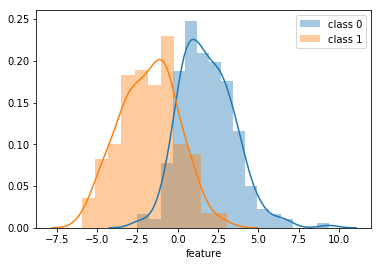

In [29]:
def contruct_lda_classifier_from_parameters(lda_paramaters, _X_train, _Y_train, n_components=None):
    solver = lda_paramaters['solver']
    shrinkage = lda_paramaters['shrinkage'] if 'shrinkage' in lda_paramaters else None
    
    return LinearDiscriminantAnalysis(
            solver=solver,
            shrinkage= None if shrinkage is None or np.isnan(shrinkage) else float(shrinkage),
            n_components=n_components
    ).fit(_X_train, _Y_train)

def build_data_frame_from_grid_with_top(grid_lda, top=10, skip=0):    
    lda_df = pd.DataFrame(grid_lda.cv_results_['params'])
    lda_df["mean_score_validation"] = grid_lda.cv_results_["mean_test_score"]
    lda_df["mean_score_training"] = grid_lda.cv_results_["mean_train_score"]
    return lda_df.sort_values(by="mean_score_validation", ascending=False).head(top+skip).tail(top)

def get_transformed_input(_grid_lda, _X_train, _Y_train):
    _lda_X_transformed = None
    for index, parameter_comnbination in build_data_frame_from_grid_with_top(_grid_lda, 20).iterrows():
        if parameter_comnbination['solver'] == 'lsqr':
            continue
        _lda_classifier = contruct_lda_classifier_from_parameters(
            parameter_comnbination, _X_train, _Y_train, n_components=1
        )
        _lda_classifier.fit(_X_train, _Y_train)
        _lda_X_transformed = _lda_classifier.transform(_X_train)
        break
    
    print('Número original de predictores:', _X_train.shape)
    print('Número reducido de predictores:', _lda_X_transformed.shape)

    return _lda_X_transformed

X_train_transformed = get_transformed_input(grid_lda, X_train_np, Y_train_np)
print('Dimensión de los datos después de la reducción de tamaño {}'.format(X_train_transformed.shape))
X_train_transformed.reshape(1,X_train_transformed.shape[0])

_df_transformed = pd.DataFrame(data={'class': Y_train_np})
_df_transformed['feature'] = X_train_transformed

print('Distribución de las clases después de reducir la dimensión')
sns.distplot(_df_transformed[_df_transformed['class'] == 0]['feature'], label='class 0')
sns.distplot(_df_transformed[_df_transformed['class'] == 1]['feature'], label='class 1')
plt.legend()
plt.show()

### Conclusión reducción de dimensión:

Al reducir la dimensión nos quedamos con sólo un 'predictor'. Esto parece emparejar a todos los clasificadores en cuanto a performance tanto para validación como para entrenamiento. El valor de auc roc obtenido sobre validación es el más alto hasta ahora.


El valor de auc roc sobre el entrenamiento es alto, lo que puede significar que estamos haciendo mucho overfitting, pero sin embargo es menor que lo obtenido en el top de otros clasificadores y tiene muy poca varianza respecto al obtenido en la validación. Esto se puede justificar otra vez por el hecho de tener un sólo predictor.

Quedarnos con un sólo predictor significa descartar mucha información, se deja como experimento a futuro considerar agregarlo al dataset inicial como un nuevo predictor para cada instancia. Se sabe que LDA hace algo similar a PCA, otro experimento a futuro nosotros mismos PCA y quedarnos con más 'predictores'.

## Random Search

Utilizaremos este mismo sobre todos los algoritmos respetando en la mayoría de los casos el mismo rango desde su valor mínimo a máximo y en otros agrandándolo (ya que hay una promesa de mejor exploración).

Se espera al explorar de una forma distinta y no tan rígida obtener valores finales distintos para cada clasificador, mejor en los casos donde no se permitió opciones automáticas (que los clasificadores puedan completar) y similar en esos casos.

In [ ]:
def apply_random_search_on_classifier_and_parameters(
    classifier, classifier_parameters_distribution, _X_train, _Y_train, metrics_names=('roc_auc'), cv=5, 
    n_jobs=4, error_score='raise', n_iter=10):
    
    _clf = RandomizedSearchCV(
        classifier, classifier_parameters_distribution, scoring=metrics_names, cv=cv, n_jobs=n_jobs,
        error_score=error_score, n_iter=n_iter, random_state=SEED
    )
    
    return _clf.fit(_X_train, _Y_train), _clf

def re_apply_random_search_on_classifier_parameters_and_random_searcher(
    random_searcher, classifier, classifier_parameters_distribution, _X_train, _Y_train, n_iter=10):
    
    random_searcher.classifier_parameters = classifier_parameters_distribution
    random_searcher.classifier = classifier
    random_searcher.n_iter=n_iter
    
    return random_searcher.fit(_X_train, _Y_train), random_searcher

def random_search_on_classifier_and_parameters(
    classifier, classifier_parameters, _X_train, _Y_train, error_score='raise', n_iter=10):
    """
    Apply random search over using the given classifier, parameters and data sets.
    
    """
    if isinstance(classifier_parameters, dict):
        classifier_parameters = [classifier_parameters]
    
    random_searcher = None
    results = None
    
    for _classifier_parameters in classifier_parameters:
        if random_searcher is None:
            results, random_searcher = apply_random_search_on_classifier_and_parameters(
                classifier, _classifier_parameters, _X_train, _Y_train, error_score=error_score, n_iter=n_iter
            )
            
        else:
            results, random_searcher = re_apply_random_search_on_classifier_parameters_and_random_searcher(
                random_searcher, classifier, _classifier_parameters, _X_train, _Y_train, n_iter=n_iter
            )
            
    return results

# Decision Tree
def tree_random_search_parametrization(_X_train, _Y_train, n_iter=25):
    _amount_of_features_in_dataset = _X_train.shape[1]

    tree_arguments = [
        {
            'criterion': ['gini', 'entropy'],
            'splitter': ['best', 'random'],
            'max_depth': randint(3, 40),
            'max_features': randint(1, _amount_of_features_in_dataset-1),
            'max_leaf_nodes': randint(10, 500)
        },
        {
            'criterion': ['gini', 'entropy'],
            'splitter': ['best', 'random'],
            'max_depth': randint(3, 40),
            'max_features': randint(1, _amount_of_features_in_dataset-1),
            'max_leaf_nodes': [None]
        },
        {
            'criterion': ['gini', 'entropy'],
            'splitter': ['best', 'random'],
            'max_depth': [None],
            'max_features': randint(1, _amount_of_features_in_dataset-1),
            'max_leaf_nodes': randint(10, 500)
        },
        {
            'criterion': ['gini', 'entropy'],
            'splitter': ['best', 'random'],
            'max_depth': [None],
            'max_features': randint(1, _amount_of_features_in_dataset-1),
            'max_leaf_nodes': randint(10, 500)
        }
    ]
    
    tree_classifier = DecisionTreeClassifier(random_state = SEED) # it doesn't seem to be taking numpy.seed
    
    return random_search_on_classifier_and_parameters(
        tree_classifier, tree_arguments, _X_train, _Y_train, n_iter=n_iter
    )

# LDA
def linear_discriminant_analysis_random_search_parametrization(_X_train, _Y_train):
    lda_arguments = [
        #{'solver': ['svd']}, Cant be applied cause space to explore is less than n_iter of RandomSearch
        {
            'solver': ['lsqr', 'eigen'],
            'shrinkage': uniform(loc=0, scale=1)
        }
    ]
    
    lda_classifier = LinearDiscriminantAnalysis()
    return random_search_on_classifier_and_parameters(lda_classifier, lda_arguments, _X_train, _Y_train)

# KNN
def knn_random_search_parametrization(_X_train, _Y_train):
    knn_arguments = [
        {
            'algorithm': ['brute'],
            'n_neighbors': randint(1, 350),
            'weights': ['distance','uniform']
        },
        {
            'algorithm': ['ball_tree', 'kd_tree'],
            'n_neighbors': randint(1, 350),
            'weights': ['distance','uniform'],
            'p': [1, 2, 200],
            'leaf_size': randint(30, 150)
        }
    ]
    
    knn_classifier = KNeighborsClassifier()
    
    return random_search_on_classifier_and_parameters(knn_classifier, knn_arguments, _X_train, _Y_train)

# SVM Generic kernels (without linear)
def generic_support_vector_machine_random_search_parametrization(_X_train, _Y_train):
    C_range = scipy.stats.gamma(0.5)
    gamma_range = scipy.stats.gamma(0.75)
    SVM_General_arguments = [
        {
            'kernel': ['rbf'],
            'C': C_range,
            'gamma': gamma_range,
            'shrinking': [True, False]
        },
        {
            'kernel': ['rbf'],
            'C': C_range,
            'gamma': ['auto'],
            'shrinking': [True, False]
        },
        {
            'kernel': ['sigmoid'],
            'coef0': uniform(loc=0, scale=10),
            'C': C_range,
            'gamma': ['auto'],
            'shrinking': [True, False]
        },
        {
            'kernel': ['poly'],
            'coef0': uniform(loc=0, scale=10),
            'gamma': ['auto'],
            'degree': randint(2, 10),
            'C': C_range,
            'shrinking': [True, False]
        }
    ]

    general_svm_classifier = sklearn.svm.SVC()
    
    return random_search_on_classifier_and_parameters(
        general_svm_classifier, SVM_General_arguments, _X_train, _Y_train
    )

# SVM Lineal
def support_vector_machine_random_serch_parametrization(_X_train, _Y_train):
    C_range = scipy.stats.gamma(0.5)
    SVM_Linear_arguments = [
        {
            'C': C_range,
            'loss': ['squared_hinge'],
            'penalty': ['l1', 'l2'],
            'dual': [False],
            'fit_intercept': [False, True]
        }
    ]

    linearsvm_classifier = sklearn.svm.LinearSVC()

    return random_search_on_classifier_and_parameters(
        linearsvm_classifier, SVM_Linear_arguments, _X_train, _Y_train
    )


print('Árboles de Decisión')
random_search_tree = tree_random_search_parametrization(X_train_np, Y_train_np)
top_results(random_search_tree)

print('LDA')
random_search_lda = linear_discriminant_analysis_random_search_parametrization(X_train_np, Y_train_np)
top_results(random_search_lda)

print('KNN')
random_search_knn = knn_random_search_parametrization(X_train_np, Y_train_np)
top_results(random_search_knn)

print('SVM Lineal')
random_search_svm_linear = support_vector_machine_random_serch_parametrization(X_train_np, Y_train_np)
top_results(random_search_svm_linear)

print('SVM Otros Kernels')
random_serach_svm_general = generic_support_vector_machine_random_search_parametrization(X_train_np, Y_train_np)
top_results(random_serach_svm_general)

### Resultados
Los resultados obtenidos son bastante parecidos a lo que se observo utilizando grid search. Hay que tener en cuenta que estamos asumiendo la distribución de varias variables sesgados en la recopilación de resultados observados en diferentes corridas de los bloques de código anteriores.


A pesar de obtener resultados bastante parecidos, el tiempo de $\textit{random search}$ es mucho menor. Esto se debe a que $\textit{grid search}$ prueba muchas más combinaciónes de parametros, puesto a que para ciertos parametros del algoritmo el $\textit{random search}$ toma valores randoms mientras que en $\textit{grid search}$ tomamos dado un rango $\textit{n}$ valores (los tiempos de cada una de las combinaciones de $\textit{random search}$ no deberian ser muy diferente a las de $\textit{grid search}$ porque se piden valores randoms de rangos parecidos, es decir, no se prueban combinaciones muy diferentes de las otras).

In [ ]:
def compare_results_grid_random_search(searching_results):
    df = pd.DataFrame(index=range(len(searching_results['algorithms_names'])))
    df["Algoritmo"] = searching_results['algorithms_names']
    df["Método de Búsqueda"] = searching_results['search_strategy']
    df["Cantidad de Combinaciones"] = searching_results['amount_combinations']
    df["Mejor AUC ROC en Entrenamiento"] = searching_results['best_train_score']
    df["Mejor AUC ROC en Validación"] = searching_results['best_test_score']
    
    display(HTML('<h3> Comparación Random vs Grid Search </h3>'))
    display(df)
    return

def get_information_from_result(result_search):
    return {
        'amount_combinations': len(result_search.cv_results_['params']),
        'best_train_score': result_search.cv_results_['mean_train_score'].max(),
        'best_test_score': result_search.cv_results_['mean_test_score'].max(),
    }

algorithms_names = ['DecisionTree', 'KNN', 'LDA', 'SVM Linear', 'SVM Generico']
grids = [grid_tree, grid_knn, grid_lda, grid_svm_linear, grid_svm_general]
randoms = [
    random_search_tree, random_search_knn, random_search_lda, random_search_svm_linear,
    random_serach_svm_general
]

def build_search_data_columns(randoms, grids, algorithms_names):
    _data = {
        'algorithms_names': [_name for _name in algorithms_names for _ in range(2)],
        'search_strategy': [_search_strategy for _ in algorithms_names for _search_strategy in ['grid', 'random'] ],
        'amount_combinations': [],
        'best_train_score': [],
        'best_test_score': []
    }

    for _result in itertools.chain(grids, randoms):
        for _k, _v in get_information_from_result(_result).items():
            _data[_k].append(_v)
    
    return _data

compare_results_grid_random_search(build_search_data_columns(randoms,grids, algorithms_names))

## Ejercicio 4: 
### Diagnóstico Sesgo-Varianza. 

En este punto, se pide inspeccionar dos de sus mejores modelos encontrados hasta ahora: el mejor modelo de tipo árbol de decisión y el mejor de tipo SVM. Para ello:

1. Graficar curvas de complejidad para cada modelo, variando la profundidad en el caso de árboles, y el hiperparámetro C en el caso de SVM. Diagnosticar cómo afectan al sesgo y a la varianza esos dos hiperparámetros.
2. Graficar curvas de aprendizaje para cada modelo. En base a estas curvas, sacar conclusiones sobre si los algoritmos parecen haber alcanzado su límite, o bien si aumentar la cantidad de datos debería ayudar.
3. Construir un modelo RandomForest con 200 árboles. Explorar para qué sirve el hiperparámetro max_features y cómo afecta a la performance del algoritmo mediante una curva de complejidad. Explicar por qué creen que se dieron los resultados obtenidos. Por último, graficar una curva de aprendizaje sobre los parámetros elegidos para determinar si sería útil o no conseguir más datos (usar  grid search para encontrar una buena combinación de parámetros).  


**Atención**: Tener en cuenta que debemos seguir utilizando ROC AUC como métrica para estas curvas.

**ver**: http://scikit-learn.org/stable/modules/learning_curve.html#learning-curve

----
**EJERCICIO EXTRA:** Utilizar RandomizedSearchCV para explorar la performance del algoritmo de Gradient Boosting y comparar con los resultados obtenidos en el punto (c).


----




In [ ]:
def validation_plot(title, classifier, X, y, param, param_range):
    train_scores, valid_scores = validation_curve(classifier, X, y, param, param_range, scoring=('roc_auc'), cv=5)
    val_results = pd.DataFrame(columns=['Param','Type','Score','Fold'])
    for i, p in enumerate(param_range):
        ts = pd.DataFrame()
        ts['Score'] = train_scores[i]
        ts['Type'] = 'train'
        ts['Fold'] = i
        ts['Param'] = p
        val_results = val_results.append(ts)
        vs = pd.DataFrame()
        vs['Score'] = valid_scores[i]
        vs['Type'] = 'valid'
        vs['Fold'] = i
        vs['Param'] = p
        val_results = val_results.append(vs)
        
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    ax = sns.pointplot(x='Param', y='Score', hue='Type', data=val_results)
    ax.set(xlabel=param)
    ax.set_title(title)
    plt.show()
    
warnings.filterwarnings(action='ignore')
tree_classifier = create_decision_tree_classifier_with_params(grid_tree.best_params_)
validation_plot('Tree classifier', tree_classifier, X_train_np, Y_train, 'max_depth', range(1,20))

unbounded_params = grid_tree.best_params_.copy()
unbounded_params['max_leaf_nodes'] = None
tree_classifier = create_decision_tree_classifier_with_params(unbounded_params)
validation_plot('Tree classifier unbounded leaf param', tree_classifier, X_train_np, Y_train, 'max_depth', range(1,20))

svm_linear_classifier = sklearn.svm.LinearSVC(
    C=grid_svm_linear.best_params_['C'], 
    loss=grid_svm_linear.best_params_['loss'],
    penalty=grid_svm_linear.best_params_['penalty'],
    dual=grid_svm_linear.best_params_['dual'],
    fit_intercept=grid_svm_linear.best_params_['fit_intercept'],
    verbose=0
)
validation_plot('SVM classifier', svm_linear_classifier, X_train_np, Y_train_np, 'C', [10**e for e in range(-3, 3)] + [5 * 10**e for e in range(-4, 3)])
warnings.filterwarnings(action='always')

### Resultado Ejercicio 4.1
Puede verse en las curvas que la varianza se dispara en ambos casos con el crecimiento del C y la máxima profundidad del árbol. También como el sesgo disminuye, ya que se le permite al algoritmo ajustarse mejor a los datos.
Al incrementar la máxima profundidad en el árbol de decisión es fácil ver que al ser más explícito y generalizar menos se puede ajustar al entrenamiento de mejor manera. Se estanca una vez llegado a profundidad 5 dado que la máxima cantidad de hojas posibles está seteada en 10. Si se le saca este parámetro el clasificador tiene peores resultados pero llega a overfittear al 100% el set de entrenamiento.
Lo mismo pasa con el parámetro C en svm, al casi no permitir errores en la separación lineal de los datos se hace mucho hincapié en instancias que pueden tener algun atributo con mucho ruido o ser un outlier.

In [ ]:
def learning_plot(title, classifier, X, y, train_sizes):
    train_sizes, train_scores, valid_scores = learning_curve(
        classifier, X, y, train_sizes=train_sizes, scoring=('roc_auc'), cv=5
    )
    val_results = pd.DataFrame(columns=['n','Type','Score','Fold'])
    for i, p in enumerate(train_sizes):
        ts = pd.DataFrame()
        ts['Score'] = train_scores[i]
        ts['Type'] = 'train'
        ts['Fold'] = i
        ts['n'] = p
        val_results = val_results.append(ts)
        vs = pd.DataFrame()
        vs['Score'] = valid_scores[i]
        vs['Type'] = 'valid'
        vs['Fold'] = i
        vs['n'] = p
        val_results = val_results.append(vs)
        
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    ax = sns.pointplot(x='n', y='Score', hue='Type', data=val_results)
    ax.set_title(title)
    plt.show()

warnings.filterwarnings(action='ignore')
tree_classifier = create_decision_tree_classifier_with_params(grid_tree.best_params_)
learning_plot('Tree classifier', tree_classifier, X_train_np, Y_train_np, np.linspace(0.1,1,10))

svm_linear_classifier = sklearn.svm.LinearSVC(
    C=grid_svm_linear.best_params_['C'],
    loss=grid_svm_linear.best_params_['loss'],
    penalty=grid_svm_linear.best_params_['penalty'],

dual=grid_svm_linear.best_params_['dual'],
    fit_intercept=grid_svm_linear.best_params_['fit_intercept'],
)
learning_plot('SVM classifier C=0.05', svm_linear_classifier, X_train_np, Y_train_np, np.linspace(0.1,1,10))

svm_linear_classifier = sklearn.svm.LinearSVC(
    C=0.005,
    loss=grid_svm_linear.best_params_['loss'],
    penalty=grid_svm_linear.best_params_['penalty'],
    dual=grid_svm_linear.best_params_['dual'],
    fit_intercept=grid_svm_linear.best_params_['fit_intercept'],
)
learning_plot('SVM classifier C=0.005', svm_linear_classifier, X_train_np, Y_train_np, np.linspace(0.1,1,10))
warnings.filterwarnings(action='always')

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200)

warnings.filterwarnings(action='ignore')
validation_plot('Random Forest classifier max_depth=None', rf, X_train_np, Y_train_np, 'max_features', [1]+[ii for ii in range(25, 201,25)] )
warnings.filterwarnings(action='always')

rf = RandomForestClassifier(n_estimators=200, max_depth=3)

warnings.filterwarnings(action='ignore')
validation_plot('Random Forest classifier max_depth=3', rf, X_train_np, Y_train_np, 'max_features', [1]+[ii for ii in range(25, 201, 25)] )
warnings.filterwarnings(action='always')

In [ ]:
rf = RandomForestClassifier(max_features=25)

warnings.filterwarnings(action='ignore')
validation_plot('Random Forest classifier max_depth=None', rf, X_train_np, Y_train_np, 'n_estimators', [1, 5, 10]+[ii for ii in range(25, 401, 25)] )
warnings.filterwarnings(action='always')

rf = RandomForestClassifier(max_features=25, max_depth=3)

warnings.filterwarnings(action='ignore')
validation_plot('Random Forest classifier max_depth=3', rf, X_train_np, Y_train_np, 'n_estimators', [1, 5, 10]+[ii for ii in range(25, 401, 25)] )
warnings.filterwarnings(action='always')

In [ ]:
rf = RandomForestClassifier(n_estimators=200, max_features=25, max_depth = 3)

warnings.filterwarnings(action='ignore')
learning_plot('Random Forest classifier max_depth=3', rf, X_train_np, Y_train_np, np.linspace(0.1,1,10) )
warnings.filterwarnings(action='always')

rf = RandomForestClassifier(n_estimators=200, max_features=25, max_depth = 5)

warnings.filterwarnings(action='ignore')
learning_plot('Random Forest classifier max_depth=5', rf, X_train_np, Y_train_np, np.linspace(0.1,1,10) )
warnings.filterwarnings(action='always')

In [ ]:
#Utilizar RandomizedSearchCV para explorar la performance del 
#algoritmo de Gradient Boosting y comparar con los resultados obtenidos en el punto (c).

from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier()
gbc_arguments = [
        {
            'loss': ['deviance', 'exponential'],
#            'learning_rate': scipy.stats.uniform(loc=0, scale=1),
            'n_estimators': scipy.stats.randint(1, 40),
            'max_depth': scipy.stats.randint(2, 8)
        }
    ]

random_search_gradient_boosting = random_search_on_classifier_and_parameters(gbc, gbc_arguments, X_train_np, Y_train_np, error_score='raise', n_iter=100)
top_results(random_search_gradient_boosting, 10)

### Resultado Ejercicio 4.2
Parece que agregando más datos de entrenamiento al clasificador de árboles de decisión se achicaría la varianza y mejoraría el score sobre validación.
En cuanto al SVM, parece bastante estancado. Eligiendo el C como se indica en el Ejercicio 4.1 se obtiene una varianza mucho mejor pagando con un mayor sesgo.

## Competencias

La entrega del trabajo estará acompañada de una competencia en la cual deberán poner a prueba su mejor modelo y sobre todo, su capacidad para estimar sus resultados. 

Su tarea será estimar la performance (AUC ROC) que tendrá su mejor modelo en datos de evaluación (X_competencia). 

Para ello, deberán predecir las probabilidades de las distintas instancias con su modelo, enviarnos dichas probabilidades junto a una estimación con 4 decimales de cuál será el AUC ROC resultante y calcularemos el resultado real. El grupo que consiga acercarse más al valor real, será el grupo ganador.  

Recomendamos no perder de vista esta competencia en el momento de separar los datos en los primeros puntos. 

Para esto, junto con la entrega del informe, deberán enviar un archivo en formato csv con las columnas “index” y “output” (ver ejemplo de archivo en: [y_competencia_ejemplo.csv](https://github.com/pbrusco/aa-notebooks/blob/master/TP1/y_competencia_ejemplo.csv)) y un valor esperado de AUC ROC. 


## Entrega
- Contarán con un esqueleto en formato Jupyter Notebook en donde tendrán que completar las celdas faltantes (ya sea con explicaciones y gráficos o código). 
- El notebook final deberá ser entregado en formatos .html e .ipynb. Es necesario que los resultados puedan reproducirse al ejecutar todas las celdas en orden (Kernel - Restart and Run All) utilizando las bibliotecas requeridas en el archivo: requirements.txt del repositorio. 
- Tienen tiempo hasta las 23:59hs del día miércoles 17/10/2018. La entrega se debe realizar a través del campus virtual y debe contener el informe.
- El trabajo deberá elaborarse en grupos de 3 personas.
- Se podrán pedir pruebas de integridad y autoría; es decir, verificar que la salida solicitada es fruto del modelo presentado y que el modelo fue construido según lo requerido en este enunciado.
- La evaluación será grupal y se basará en la calidad del informe (presentación, claridad, prolijidad); la originalidad, practicidad y coherencia técnica de la solución; la corrección y solidez de las pruebas realizadas.
- En el primer parcial se incluirá una pregunta sobre la solución entregada. Esa pregunta no influirá en la nota del parcial, pero sí en la nota individual del TP1.
- La participación en la competencia es obligatoria. De todas maneras, el resultado no incidirán en la nota de la materia.
- Los ejercicios extra son opcionales para aprobar el TP, pero son obligatorios para promocionar la materia.
